# Navigation

---
This notebook is based on the code of the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893). <br>
In this notebook, we will **train an Agent with Priorized Experience Replay**.

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [11]:
from unityagents import UnityEnvironment
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import torch

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [12]:
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana_Windows_x86_64/Banana.exe")#, no_graphics=False

UnityTimeOutException: Couldn't start socket communication because worker number 0 is still in use. You may need to manually close a previously opened environment or use a different worker number.

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

The code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)
0
# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Training
Let import our [deep-Q-learning agent with Priorized Experience Replay](https://github.com/kossowski-pierre/dqn_navigation/blob/main/agent_dqn.py) and train it to solve banana Unity Environment.

In [5]:
from agent_dqn import AgentDQN

Episode 100	Average Score: 1.73
Episode 200	Average Score: 6.75
Episode 300	Average Score: 9.47
Episode 400	Average Score: 12.85
Episode 422	Average Score: 13.05
Environment solved in 322 episodes!	Average Score: 13.05


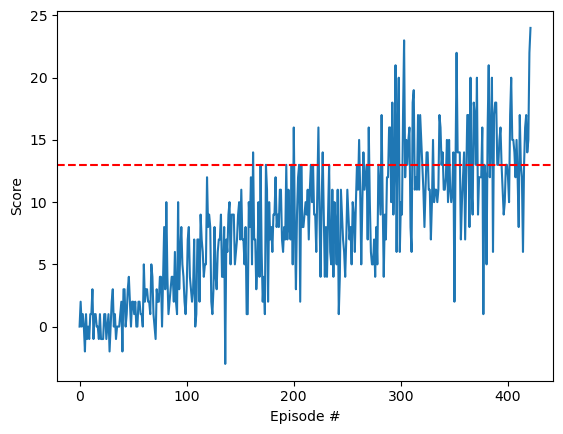

In [6]:
agent = AgentDQN(state_size=state_size, action_size=action_size)
def train_DQN(n_episodes = 2000, max_t = 1000, eps_start=1, eps_decay=100, eps_min=0.01, b_decay=10000):
    
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_min (float): minimum value of epsilon
        eps_decay (float): controls the rate of exponential decay of epsilon, higher means a slower decay
        b_decay (float): controls the rate of exponential decay of b, higher means a slower decay
    """
    scores = []
    scores_window = deque(maxlen = 100)
    eps = eps_start
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state 
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            
            score += reward                                # update the score
            state = next_state
            
            if done:
                break
        scores_window.append(score)
        scores.append(score)
        eps = eps_min+(eps_start-eps_min)*np.exp(-1*i_episode/eps_decay)#epsilon decrease to 0
        #agent.memory.b=0.7-(0.7-agent.memory.b)*np.exp(-1*i_episode/b_decay)# b (=beta) slowly increase to 0.7 (~1)
        agent.memory.b=1-(1-agent.memory.b)*np.exp(-1*i_episode/b_decay)# b (=beta) slowly increase to 1
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.policy_net.state_dict(), 'model.pth')
            break
    return scores

scores = train_DQN()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.axhline(y=13, color='r', linestyle='--')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Let observe our trained Agent
In the code below, we see our trained agent in action.

In [7]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.act(state, eps=0)                 # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: -1.0


In [13]:
env.close()

UnityEnvironmentException: No Unity environment is loaded.

In [9]:
agent.memory.b

0.9998736675071389